# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

---

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (i.e. transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio

#### Basic Infos:

In [3]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
print(f'The shape of portfolio data is {portfolio.shape}\n')
print(f'Null values statistics is: \n{portfolio.isnull().sum()}\n')
print(f'There are {portfolio.id.nunique()} unique ids.\n')

The shape of portfolio data is (10, 6)

Null values statistics is: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

There are 10 unique ids.



Text(0.5, 1.0, 'Offer Type Distribution')

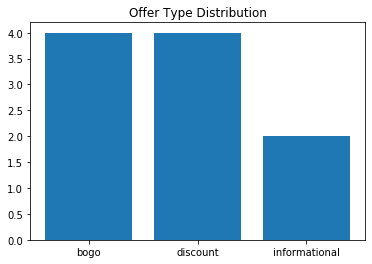

In [5]:
plt.bar(['bogo', 'discount', 'informational'], 
        portfolio.groupby('offer_type').id.count())

plt.title('Offer Type Distribution')

### 2. Profiles

#### Basic Infos:

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**NOTE:** from the `head` we can already see that there are missing values in `income` and `gender`, and `118` seems to represent missing ages.

In [7]:
print(f'The shape of Profile data is {profile.shape}')
print(f'Null values statistics is: \n{profile.isnull().sum()}')
print(f'There are {profile.id.nunique()} unique ids.')

The shape of Profile data is (17000, 5)
Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
There are 17000 unique ids.


In [8]:
profile_no_age = profile[profile.age==118]
print(f'The shape of the subset is {profile_no_age.shape}\n')
print(f'Null values statistics is: \n{profile_no_age.isnull().sum()}')
profile_no_age.head()

The shape of the subset is (2175, 5)

Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


From above we can see that rows without `age` also miss `income` and `gender`, hence, these rows will be dropped in later operations. 

#### Distributions:

In [9]:
profile['mbr_since'] = pd.to_datetime(profile['became_member_on'],
                                      format='%Y%m%d')
latest_member_date = profile['mbr_since'].max()

profile['mbr_shp_len'] = latest_member_date - profile['mbr_since']

Text(0.5, 1.0, 'Membership Length Distribution in Years')

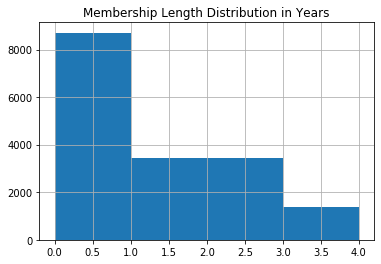

In [10]:
profile.mbr_shp_len.astype('timedelta64[Y]').hist(bins=4)
plt.title('Membership Length Distribution in Years')

In [11]:
profile['mbr_shp_len'] = profile['mbr_shp_len'].dt.days.astype('float64')

Text(0.5, 1.0, 'Gender Distribution')

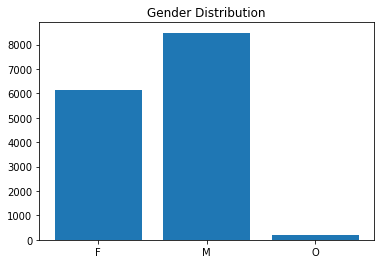

In [12]:
plt.bar(['F', 'M', 'O'],profile.groupby('gender').id.count())
plt.title('Gender Distribution')

Text(0.5, 1.0, '60+ yrs Old Other Income Distribution')

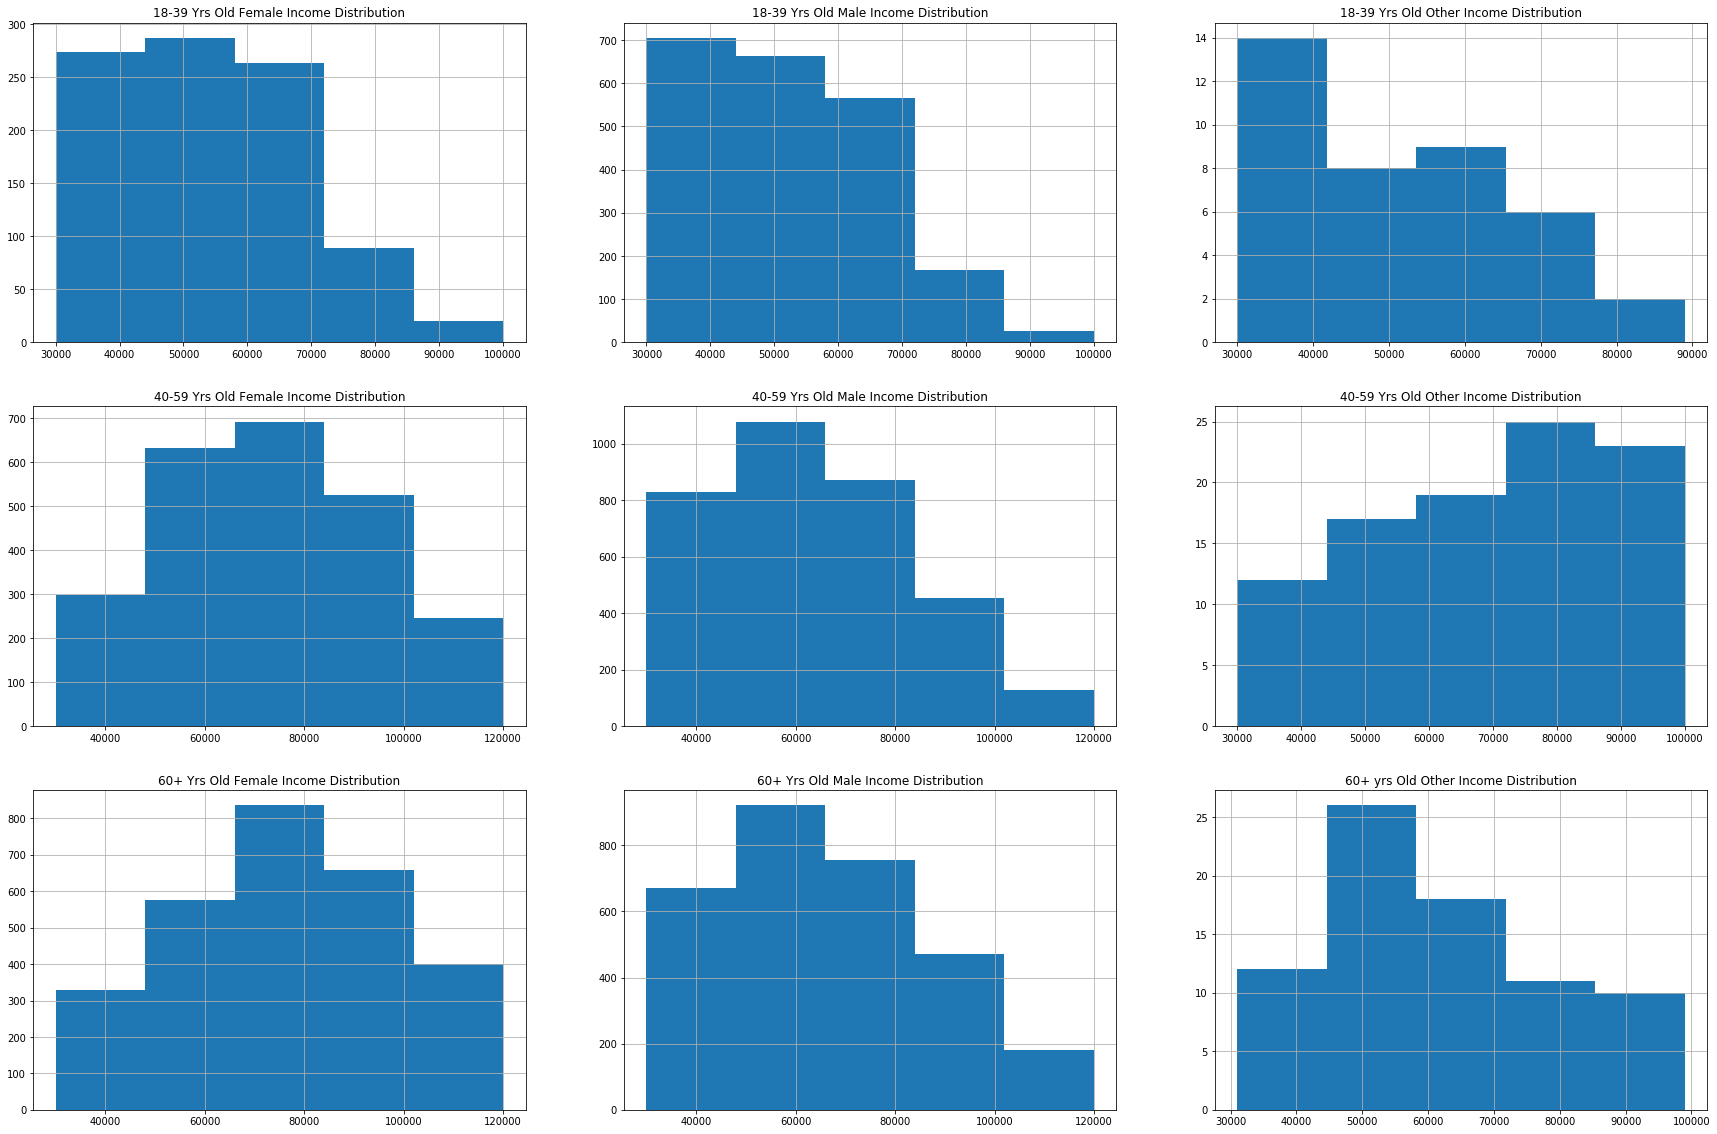

In [13]:
plt.figure(figsize=(30, 20))

plt.subplot(331)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('18-39 Yrs Old Female Income Distribution')

plt.subplot(332)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('18-39 Yrs Old Male Income Distribution')

plt.subplot(333)
profile[(profile.age>=18) & \
        (profile.age<40) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('18-39 Yrs Old Other Income Distribution')

plt.subplot(334)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('40-59 Yrs Old Female Income Distribution')

plt.subplot(335)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('40-59 Yrs Old Male Income Distribution')

plt.subplot(336)
profile[(profile.age>=40) & \
        (profile.age<60) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('40-59 Yrs Old Other Income Distribution')

plt.subplot(337)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='F')].income.hist(bins=5)
plt.title('60+ Yrs Old Female Income Distribution')

plt.subplot(338)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='M')].income.hist(bins=5)
plt.title('60+ Yrs Old Male Income Distribution')

plt.subplot(339)
profile[(profile.age>=60) & \
        (profile.age!=118) & \
        (profile.gender=='O')].income.hist(bins=5)
plt.title('60+ yrs Old Other Income Distribution')

### 3. Transcript

#### Basic Infos:

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
print(f'The shape of Transcript data is {transcript.shape}\n')
print(f'Null values statistics is: \n{transcript.isnull().sum()}\n')
print(f'There are {transcript.person.nunique()} unique ids.')

The shape of Transcript data is (306534, 4)

Null values statistics is: 
person    0
event     0
value     0
time      0
dtype: int64

There are 17000 unique ids.


#### Distributions

Text(0.5, 1.0, 'Event Distribution')

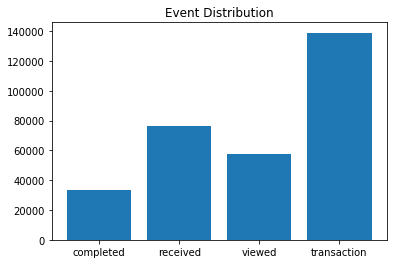

In [16]:
plt.bar(['completed', 'received', 'viewed', 'transaction'], 
        transcript.groupby('event').person.count())

plt.title('Event Distribution')

---

## Preprocessing

### 1. Merge `portfolio` and `transcript`

To find out the connection between transaction and offer, we need to combine the information in `portfolio` and `transcript`, and then create subsets of different offer-event combination for later feature engineering and modeling.

Before the merge, it's better to process the `value` column to extract offer ids.

In [17]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], 
                       axis=1)

transcript['clean_id'] = np.where(transcript['offer id'].isnull() & 
                                  transcript['offer_id'].notnull(), 
                                  transcript['offer_id'],
                                  transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

transcript = transcript.merge(portfolio,
                              how='left',
                              left_on='offer_id',
                              right_on='id')

Text(0.5, 1.0, 'Number of Offers in Transcripts by Type')

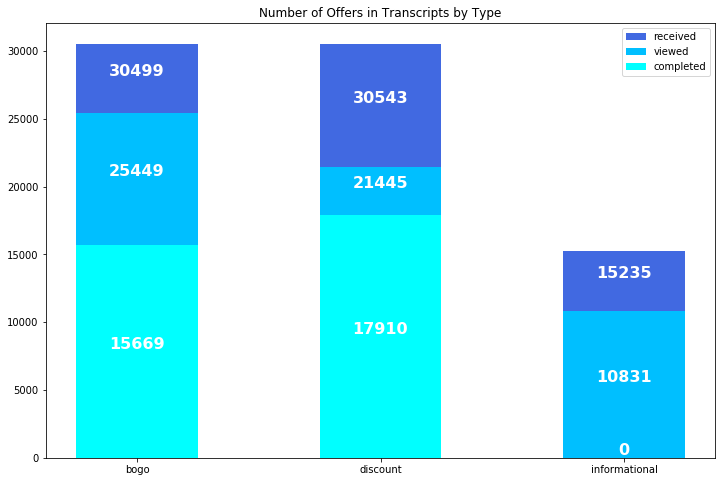

In [18]:
# plot merged dataset offer types 
offer_cnt = transcript.groupby(['event', 'offer_type'])['offer_type'].count()
complete_cnt = [offer_cnt[0], offer_cnt[1], 0]
receive_cnt = offer_cnt[2:5]
view_cnt = offer_cnt[5:]

x = ['bogo', 'discount', 'informational']

plt.figure(figsize=(12, 8))

ax1 = plt.bar(x, receive_cnt, width=0.5, color='royalblue',
              label='received', align='center')
ax2 = plt.bar(x, view_cnt, width=0.5, color='deepskyblue',
              label='viewed', align='center')
ax3 = plt.bar(x, complete_cnt, width=0.5, color='aqua',
              label='completed', align='center')

for r1, r2, r3 in zip(ax3, ax2, ax1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    
    plt.text(r1.get_x() + r1.get_width() / 2., 
             h1 / 2., 
             "%d" % h1, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r2.get_x() + r2.get_width() / 2., 
             h1 + (h2 - h1) / 2., 
             "%d" % h2, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r3.get_x() + r3.get_width() / 2., 
             h2 + (h3 - h2) / 2., 
             "%d" % h3, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")

plt.legend(loc='upper right')
plt.title('Number of Offers in Transcripts by Type')

### 2. Split Transcript into Offer Related and Unrelated Subset

Idealy, we have the following typical customer behaviours:

    1. make the transaction after receiving and viewing the offer

    2. viewing the offer and make no transaction

    3. make the transaction without receiving or viewing the offer

As for offer types, we can see from above that `offer_id` is not directly linked to `transaction` events, hence, we need to establish these links.

For `bogo` and `discount` offer, they have an obvious consequence of offer received, viewed, transaction and hence the offer completes.

However, for the `information` offer, there's no reward step for the easy links to transactions, we need a work around.

Before flagging any data, we need to reorganize the data first.

In [19]:
# drop the dummy columns created by `merge`
transcript_processed = transcript.drop(columns=['reward_x',
                                                'reward_y',
                                                'id',
                                                'value'],
                                       axis=1, inplace=False)

transcript_processed['email'] = 0
transcript_processed['mobile'] = 0
transcript_processed['social'] = 0
transcript_processed['web'] = 0

for i in range(transcript_processed.shape[0]):
    try:
        transcript_processed['email'].iloc[i] = \
                np.where(('email' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['mobile'].iloc[i] = \
                np.where(('mobile' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['social'].iloc[i] = \
                np.where(('social' in transcript_processed.channels.iloc[i]),
                         1, 0)
    
        transcript_processed['web'].iloc[i] = \
                np.where(('web' in transcript_processed.channels.iloc[i]),
                         1, 0)
    except:
        pass

transcript_processed.drop(columns=['channels'], axis=1, inplace=True)
transcript_processed['time'] = transcript_processed['time'] / 24
    
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person',
                                                         'time']).reset_index()


/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
transcript_processed.head(20)

,index,person,event,time,amount,offer_id,difficulty,duration,offer_type,email,mobile,social,web
0,55972,0009655768c64bdeb2e877511632db8f,offer received,7.00,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,1,1,1,0
1,77705,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,1,1,1,0
2,89291,0009655768c64bdeb2e877511632db8f,transaction,9.50,22.16,NaN,NaN,NaN,NaN,0,0,0,0
3,113605,0009655768c64bdeb2e877511632db8f,offer received,14.00,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,1,1,0,1
4,139992,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,1,1,0,1
5,153401,0009655768c64bdeb2e877511632db8f,offer received,17.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
6,168412,0009655768c64bdeb2e877511632db8f,transaction,17.25,8.57,NaN,NaN,NaN,NaN,0,0,0,0
7,168413,0009655768c64bdeb2e877511632db8f,offer completed,17.25,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
8,187554,0009655768c64bdeb2e877511632db8f,offer viewed,19.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,1,1,1,1
9,204340,0009655768c64bdeb2e877511632db8f,offer received,21.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,1,1,1,1


From above data, we can see that many `offer completed` events happened before the `offer viewed` event correspond to the same offer.

In [21]:
person_offer_cols = ['person', 'amount', 'offer_id', 'offer_type',
                     'difficulty', 'duration', 'email', 'mobile', 
                     'social', 'web', 'received', 'viewed',
                     'completed', 'transaction',
                     'receive_time', 'transaction_time']

unrelated_cols = ['person', 'amount', 'time']

person_offer = []

unrelated_transaction = []

**NOTE:** the code cell below is very long to read line by line, as it's brutally implementing a simple logic, any offer related transactions should start with a 'offer_received' event. 

From above data exploration, we can see that there are offers which are 'completed' before 'viewed'. Even these offers count, but 'received' should be the first event of any offer related transactions, otherwise, the transaction is unrelated to any offer.

In [22]:
received = False
viewed = False
completed = False
transaction = False

for i in range(transcript_processed.shape[0]):
    
    if viewed:
        viewed = False
        continue
    if completed:
        completed = False
        continue
    if transaction:
        transaction = False
        continue
    
    # received - viewed - comlpeted - transaction
    if transcript_processed.event.iloc[i] == 'offer received':
        received = True
        person = transcript_processed.person.iloc[i]
        ofr_id = transcript_processed.offer_id.iloc[i]
        start_time = transcript_processed.time.iloc[i]
        duration = transcript_processed.duration.iloc[i]

        if (transcript_processed.person.iloc[i+1] == person) and \
           (transcript_processed.offer_id.iloc[i+1] == ofr_id) and \
           (transcript_processed.event.iloc[i+1] == 'offer viewed'):
            viewed = True
            
            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer completed'):
                completed = True
                
                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'transaction'):
                    transaction = True
                    end_time = transcript_processed.time.iloc[i+3]
                    time_diff = end_time - start_time

                    if time_diff <= duration:
                        new_entry = [transcript_processed.person.iloc[i],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.offer_id.iloc[i],
                                     transcript_processed.offer_type.iloc[i],
                                     transcript_processed.difficulty.iloc[i],
                                     transcript_processed.duration.iloc[i],
                                     transcript_processed.email.iloc[i],
                                     transcript_processed.mobile.iloc[i],
                                     transcript_processed.social.iloc[i],
                                     transcript_processed.web.iloc[i],
                                     received, viewed,
                                     completed, transaction,
                                     start_time, end_time]

                        person_offer.append(new_entry)

                    elif time_diff > duration:
                        new_entry = [transcript_processed.person.iloc[i+3],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.time.iloc[i+3]]

                        unrelated_transaction.append(new_entry)
            
            # received - viewed - transaction - comlpeted
            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'transaction'):
                transaction = True
                end_time = transcript_processed.time.iloc[i+2]

                if end_time - start_time <= duration:

                    if (transcript_processed.person.iloc[i+3] == person) and \
                       (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                       (transcript_processed.event.iloc[i+3] == \
                        'offer completed'):
                        completed = True

                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif end_time - start_time > duration:
                    new_entry = [transcript_processed.person.iloc[i+2],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.time.iloc[i+2]]

                    unrelated_transaction.append(new_entry)

        # received - comlpeted - viewed - transaction 
        elif (transcript_processed.person.iloc[i+1] == person) and \
             (transcript_processed.offer_id.iloc[i+1] == ofr_id) and \
             (transcript_processed.event.iloc[i+1] == 'offer completed'):
            completed = True

            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer viewed'):
                viewed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'transaction'):
                    transaction = True
                    end_time = transcript_processed.time.iloc[i+3]
                    time_diff = end_time - start_time

                    if time_diff <= duration:
                        new_entry = [transcript_processed.person.iloc[i],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.offer_id.iloc[i],
                                     transcript_processed.offer_type.iloc[i],
                                     transcript_processed.difficulty.iloc[i],
                                     transcript_processed.duration.iloc[i],
                                     transcript_processed.email.iloc[i],
                                     transcript_processed.mobile.iloc[i],
                                     transcript_processed.social.iloc[i],
                                     transcript_processed.web.iloc[i],
                                     received, viewed,
                                     completed, transaction,
                                     start_time, end_time]

                        person_offer.append(new_entry)

                    elif time_diff > duration:
                        new_entry = [transcript_processed.person.iloc[i+3],
                                     transcript_processed.amount.iloc[i+3],
                                     transcript_processed.time.iloc[i+3]]

                        unrelated_transaction.append(new_entry)

            # received - comlpeted - transaction - viewed 
            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'transaction'):

                transaction = True
                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                   (transcript_processed.event.iloc[i+3] == 'offer viewed'):
                    viewed = True

                end_time = transcript_processed.time.iloc[i+3]
                time_diff = end_time - start_time

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+2],
                                 transcript_processed.amount.iloc[i+2],
                                 transcript_processed.time.iloc[i+2]]

                    unrelated_transaction.append(new_entry)
        
        # received - transaction - viewed - comlpeted
        elif (transcript_processed.person.iloc[i+1] == person) and \
             (transcript_processed.event.iloc[i+1] == 'transaction'):
            transaction = True
            end_time = transcript_processed.time.iloc[i+1]
            time_diff = end_time - start_time

            if (transcript_processed.person.iloc[i+2] == person) and \
               (transcript_processed.offer_id.iloc[i+2] == ofr_id) and \
               (transcript_processed.event.iloc[i+2] == 'offer viewed'):
                viewed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.event.iloc[i+3] == 'offer completed'):
                    completed = True

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+1],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.time.iloc[i+1]]

                    unrelated_transaction.append(new_entry)

            # received - transaction - comlpeted - viewed
            elif (transcript_processed.person.iloc[i+2] == person) and \
                 (transcript_processed.event.iloc[i+2] == 'offer completed'):
                completed = True

                if (transcript_processed.person.iloc[i+3] == person) and \
                   (transcript_processed.offer_id.iloc[i+3] == ofr_id) and \
                   (transcript_processed.event.iloc[i+3] == 'offer viewed'):
                    viewed = True

                end_time = transcript_processed.time.iloc[i+3]
                time_diff = end_time - start_time

                if time_diff <= duration:
                    new_entry = [transcript_processed.person.iloc[i],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.offer_id.iloc[i],
                                 transcript_processed.offer_type.iloc[i],
                                 transcript_processed.difficulty.iloc[i],
                                 transcript_processed.duration.iloc[i],
                                 transcript_processed.email.iloc[i],
                                 transcript_processed.mobile.iloc[i],
                                 transcript_processed.social.iloc[i],
                                 transcript_processed.web.iloc[i],
                                 received, viewed,
                                 completed, transaction,
                                 start_time, end_time]

                    person_offer.append(new_entry)

                elif time_diff > duration:
                    new_entry = [transcript_processed.person.iloc[i+1],
                                 transcript_processed.amount.iloc[i+1],
                                 transcript_processed.time.iloc[i+1]]

                    unrelated_transaction.append(new_entry)

    elif transcript_processed.event.iloc[i] == 'transaction':
        new_entry = [transcript_processed.person.iloc[i],
                     transcript_processed.amount.iloc[i],
                     transcript_processed.time.iloc[i]]

        unrelated_transaction.append(new_entry)


In [23]:
person_offer_df = pd.DataFrame(person_offer, columns=person_offer_cols)

unrelated_transaction_df = pd.DataFrame(unrelated_transaction,
                                        columns=unrelated_cols)

person_offer_df = person_offer_df.drop_duplicates()
unrelated_transaction_df = unrelated_transaction_df.drop_duplicates()

In [24]:
person_offer_df.head(20)

,person,amount,offer_id,offer_type,difficulty,duration,email,mobile,social,web,received,viewed,completed,transaction,receive_time,transaction_time
0,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,1,1,1,0,True,True,False,True,7.0,9.50
1,0009655768c64bdeb2e877511632db8f,8.57,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,1,1,1,1,True,True,True,True,17.0,19.00
2,0009655768c64bdeb2e877511632db8f,14.11,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,1,1,1,1,True,True,True,True,21.0,22.50
3,0009655768c64bdeb2e877511632db8f,10.27,2906b810c7d4411798c6938adc9daaa5,discount,10.0,7.0,1,1,0,1,True,False,True,True,24.0,27.50
4,0011e0d4e6b944f998e987f904e8c1e5,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0,1,1,1,1,True,True,True,True,7.0,10.50
5,0011e0d4e6b944f998e987f904e8c1e5,22.05,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,1,1,0,1,True,True,False,True,21.0,24.00
6,0020c2b971eb4e9188eac86d93036a77,17.63,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,1,1,1,1,True,True,True,True,0.0,2.25
7,0020c2b971eb4e9188eac86d93036a77,17.24,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,1,1,1,0,True,False,True,True,21.0,21.25
8,0020ccbbb6d84e358d3414a3ff76cffd,11.65,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0,1,1,1,1,True,True,True,True,7.0,9.25
9,0020ccbbb6d84e358d3414a3ff76cffd,14.53,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0,1,1,1,1,True,True,True,True,14.0,15.75


In [25]:
unrelated_transaction_df.head(20)

,person,amount,time
0,0009655768c64bdeb2e877511632db8f,13.56,23.00
1,0009655768c64bdeb2e877511632db8f,12.36,27.50
2,0009655768c64bdeb2e877511632db8f,28.16,28.75
3,0009655768c64bdeb2e877511632db8f,18.41,29.00
4,00116118485d4dfda04fdbaba9a87b5c,0.70,12.25
5,00116118485d4dfda04fdbaba9a87b5c,0.20,19.00
6,00116118485d4dfda04fdbaba9a87b5c,3.19,19.75
7,0011e0d4e6b944f998e987f904e8c1e5,13.49,5.50
8,0011e0d4e6b944f998e987f904e8c1e5,23.03,26.75
9,0011e0d4e6b944f998e987f904e8c1e5,8.96,27.25


---

## Feature engineering

In this session, let's add some new features based on given ones for later model building.

The `profile` dataset will be used in model building after adding the following features:

### New Feature Set 1

* transaction amount unrelated to offers

* transaction amount related to offers

* total transaction amount

* amount of profit in best offer related transactions (largest transaction after substracting offer reward)

* offer id of best offer

In [26]:
offer_profit = []

for i in range(person_offer_df.shape[0]):
    reward = portfolio[portfolio['id']==person_offer_df.offer_id.iloc[i]] \
                      ['reward'].values[0]
    amt = person_offer_df.amount.iloc[i]
    offer_profit.append(amt - reward)

person_offer_df['offer_profit'] = offer_profit

In [27]:
unrelated_amt_df = pd.DataFrame({'id': unrelated_transaction_df \
                                     .groupby('person').amount.sum().index,
                                 'unrelated_amount': unrelated_transaction_df \
                                     .groupby('person').amount.sum().values})

offer_amt_df = pd.DataFrame({'id': person_offer_df.groupby('person') \
                                 .amount.sum().index,
                             'offer_amount': person_offer_df.groupby('person') \
                                 .amount.sum().values})

offer_profit_df = pd.DataFrame({'id': person_offer_df.groupby('person') \
                                    .offer_profit.sum().index,
                                'total_profit': person_offer_df \
                                    .groupby('person') \
                                    .offer_profit.sum().values})

clean_profile = profile.merge(unrelated_amt_df, how='left', on='id')
clean_profile = clean_profile.merge(offer_amt_df, how='left', on='id')
clean_profile = clean_profile.merge(offer_profit_df, how='left', on='id')

clean_profile = clean_profile[clean_profile['age']!=118].reset_index()

clean_profile.unrelated_amount = clean_profile.unrelated_amount.fillna(0.0)

clean_profile['total_amount'] = clean_profile['unrelated_amount'] + \
                                clean_profile['offer_amount']

In [28]:
best_profit_df = pd.DataFrame({'id': person_offer_df.groupby('person') \
                                   .offer_profit.max().index,
                               'best_profit': person_offer_df \
                                   .groupby('person') \
                                   .offer_profit.max().values})

clean_profile = clean_profile.merge(best_profit_df, how='left', on='id')

best_offer_dict = {'id': person_offer_df.groupby('person') \
                       .offer_profit.idxmax().index,
                   'best_offer': person_offer_df.offer_id.iloc[
                       person_offer_df.groupby('person') \
                           .offer_profit.idxmax().values]}

best_offer_df = pd.DataFrame(best_offer_dict)

clean_profile = clean_profile.merge(best_offer_df, how='left', on='id')

In [29]:
clean_profile.head()

,index,gender,age,id,became_member_on,income,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,376.0,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,443.0,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,91.0,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4
3,8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09,167.0,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017-11-11,257.0,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4


Buying coffee and light food is a kind of daily expanse, we can change the representation of income to weekly level. And calculating the total income since membership can also give us the ratio of coffee expense for each customer. 

Also, the ratio of actual transaction to the difficulty of the offer is also a good feature of ones coffee buying behaviour.

**NOTE:** for `informational` offers, they don't have a difficulty, so I took the ratio of `total_amount` to `unrelated_amount` instead.

### New Feature Set 2

* weekly income

* total income since joined membership

* ratio of offer related transaction amount in total amount

* ratio of total transaction amount in total income since joined membership

* mean ratio of transaction amount to offer difficulty

In [30]:
clean_profile['weekly_income'] = clean_profile['income'] / 52

clean_profile['income_since_mbrshp'] = \
    clean_profile['weekly_income'] * \
    clean_profile['mbr_shp_len'] / 7.0

clean_profile.drop(columns=['income', 'became_member_on'],
                   axis=1, inplace=True)

clean_profile['offer_amt_ratio'] = clean_profile.offer_amount / \
                                   clean_profile.total_amount
clean_profile['coffee_expanse_ratio'] = clean_profile.total_amount / \
                                        clean_profile.income_since_mbrshp

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376.0,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,115692.307692,0.301519,0.000666
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443.0,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121703.296703,0.384755,0.001309
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91.0,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167.0,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,24315.934066,1.000000,0.001498
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257.0,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,36008.241758,0.487196,0.000434


In [31]:
person_info_df = \
    person_offer_df[person_offer_df['offer_type']=='informational']
person_bogo_discnt_df = \
    person_offer_df[person_offer_df['offer_type']!='informational']

In [32]:
person_bogo_discnt_df['ratio'] = person_bogo_discnt_df['amount'] / \
                                 person_bogo_discnt_df['difficulty']
offer_ratio_df = pd.DataFrame({'id': person_bogo_discnt_df \
                                   .groupby('person').ratio.mean().index,
                               'mean_ratio': person_bogo_discnt_df \
                                   .groupby('person').ratio.mean().values})

clean_profile = clean_profile.merge(offer_ratio_df, how='left', on='id')


clean_profile['only_info'] = np.where(np.isnan(clean_profile.mean_ratio), 1, 0)

for i in range(clean_profile.shape[0]):
    if np.isnan(clean_profile.mean_ratio.iloc[i]):
        clean_profile.mean_ratio.iloc[i] = \
            clean_profile.total_amount.iloc[i] / \
            clean_profile.unrelated_amount.iloc[i]

clean_profile.dropna()

/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376.0,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,115692.307692,0.301519,0.000666,1.431679,1
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443.0,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121703.296703,0.384755,0.001309,4.161000,0
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91.0,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299,1.842000,0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167.0,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,24315.934066,1.000000,0.001498,2.053333,0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257.0,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,36008.241758,0.487196,0.000434,0.430214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,16992,F,21,400d0536e8794cbb855b0d882d67cbda,2017-09-17,312.0,10.54,6.77,-1.23,17.31,-0.54,2298d6c36e964ae4a3e7e9706d1fb8c2,1384.615385,61714.285714,0.391103,0.000280,0.606714,0
14820,16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,52.0,16.97,3.06,0.06,20.03,0.06,2298d6c36e964ae4a3e7e9706d1fb8c2,1038.461538,7714.285714,0.152771,0.002596,0.437143,0
14821,16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,13.0,17.09,6.46,1.46,23.55,1.46,9b98b8c7a33c4b65b9aebfe6a799e6d9,1384.615385,2571.428571,0.274310,0.009158,1.292000,0
14823,16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,871.0,156.58,33.09,8.09,189.67,6.03,9b98b8c7a33c4b65b9aebfe6a799e6d9,961.538462,119642.857143,0.174461,0.001585,1.470667,0


In [33]:
clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,376.0,53.79,23.22,23.22,77.01,23.22,3f207df678b143eea3cee63160fa8bed,2153.846154,115692.307692,0.301519,0.000666,1.431679,1
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,443.0,97.99,61.28,51.28,159.27,19.67,5a8bc65990b245e5a138643cd4eb9837,1923.076923,121703.296703,0.384755,0.001309,4.161000,0
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,91.0,39.31,18.42,16.42,57.73,16.42,fafdcd668e3743c1bb461111dcafc2a4,1346.153846,17500.000000,0.319072,0.003299,1.842000,0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,167.0,0.00,36.43,24.43,36.43,10.63,9b98b8c7a33c4b65b9aebfe6a799e6d9,1019.230769,24315.934066,1.000000,0.001498,2.053333,0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,257.0,8.01,7.61,2.61,15.62,3.29,fafdcd668e3743c1bb461111dcafc2a4,980.769231,36008.241758,0.487196,0.000434,0.430214,0


When building models, polynomials of given feature can also be beneficial to performance, but for now, we are not going to do so. My preference in feature engineering is natural and logical combinations of features instead of numerical manipulations.

### One More Thing

As mentioned in introduction, there are a group of customers who spend quite a few amount of money in Starbucks despite of any offer. So, from a commercial perspective, we don't want to send them any offer at all. Here, I assign `no_offer` as `best_offer` to customers of `offer_amt_ratio` lower than 15%.

In [34]:
clean_profile.sort_values(by=['unrelated_amount'],
                          ascending=False, inplace=True)

clean_profile['no_offer'] = np.where((clean_profile['offer_amt_ratio']<=0.15),
                                     1, 0)

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,best_profit,best_offer,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info,no_offer
2391,2753,F,43,d240308de0ee4cf8bb6072816268582b,2017-06-30,391.0,1161.31,75.99,55.99,1237.30,18.22,ae264e3637204a6fb9bb56bc8210ddfd,1807.692308,100972.527473,0.061416,0.012254,2.483536,0,1
3379,3909,M,67,6406abad8e2c4b8584e4f68003de148d,2016-02-28,879.0,1158.26,53.50,36.50,1211.76,13.34,f19421c1d4aa40978ebb69ca19b0e20d,1519.230769,190771.978022,0.044151,0.006352,2.394667,0,1
11539,13211,M,55,52959f19113e4241a8cb3bef486c6412,2016-12-20,583.0,1155.58,113.30,83.30,1268.88,31.35,ae264e3637204a6fb9bb56bc8210ddfd,2134.615385,177782.967033,0.089291,0.007137,4.101500,0,1
14615,16752,M,58,946fc0d3ecc4492aa4cc06cf6b1492c3,2017-06-04,417.0,1107.14,125.26,108.26,1232.40,33.71,9b98b8c7a33c4b65b9aebfe6a799e6d9,1519.230769,90502.747253,0.101639,0.013617,4.088500,0,1
11658,13351,M,81,4d0ebb94a5a94fe6afd9350c7b1477e4,2016-01-16,922.0,1077.69,75.25,50.25,1152.94,30.18,0b1e1539f2cc45b7b9fa7c272da2e1d7,2250.000000,296357.142857,0.065268,0.003890,1.922000,0,1


---

## Modeling

After pre-processing, the next step is to implement models to predict best offers for given customers.

The process includes the following steps:

1. Data Preparation

    Form feature matrix and label matrix from dataset, and than split them into training set and test set.

2. Metrics and Helper Functions

    The performance metrics for the model and some helper functions.

3. Building model

    Construct and train the model.

4. Model Tuning

    Tune the model for better performance via GridSearch.

### Data Preparation

In [35]:
one_hot_gender_df = pd.get_dummies(clean_profile['gender'])

clean_profile = pd.concat([clean_profile, one_hot_gender_df], axis=1)
clean_profile = clean_profile[~np.isnan(clean_profile.offer_amount)]

clean_profile.head()

,index,gender,age,id,mbr_since,mbr_shp_len,unrelated_amount,offer_amount,total_profit,total_amount,...,weekly_income,income_since_mbrshp,offer_amt_ratio,coffee_expanse_ratio,mean_ratio,only_info,no_offer,F,M,O
2391,2753,F,43,d240308de0ee4cf8bb6072816268582b,2017-06-30,391.0,1161.31,75.99,55.99,1237.30,...,1807.692308,100972.527473,0.061416,0.012254,2.483536,0,1,1,0,0
3379,3909,M,67,6406abad8e2c4b8584e4f68003de148d,2016-02-28,879.0,1158.26,53.50,36.50,1211.76,...,1519.230769,190771.978022,0.044151,0.006352,2.394667,0,1,0,1,0
11539,13211,M,55,52959f19113e4241a8cb3bef486c6412,2016-12-20,583.0,1155.58,113.30,83.30,1268.88,...,2134.615385,177782.967033,0.089291,0.007137,4.101500,0,1,0,1,0
14615,16752,M,58,946fc0d3ecc4492aa4cc06cf6b1492c3,2017-06-04,417.0,1107.14,125.26,108.26,1232.40,...,1519.230769,90502.747253,0.101639,0.013617,4.088500,0,1,0,1,0
11658,13351,M,81,4d0ebb94a5a94fe6afd9350c7b1477e4,2016-01-16,922.0,1077.69,75.25,50.25,1152.94,...,2250.000000,296357.142857,0.065268,0.003890,1.922000,0,1,0,1,0


In [36]:
y = pd.concat([pd.get_dummies(clean_profile['best_offer']),
               clean_profile['no_offer']], axis=1)

offer_dict = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
              '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
              '3f207df678b143eea3cee63160fa8bed': 'info_1',
              '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
              '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discnt_1',
              '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discnt_2',
              'fafdcd668e3743c1bb461111dcafc2a4': 'discnt_3',
              '5a8bc65990b245e5a138643cd4eb9837': 'info_2',
              'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
              '2906b810c7d4411798c6938adc9daaa5': 'discnt_4'}

reversed_offer_dict = {value:key for key, value in offer_dict.items()}

y.rename(columns=offer_dict, inplace=True)

cls_labels = list(y.columns.values)
y = y.to_numpy()

In [37]:
feat_list = ['F', 'M', 'O']
std_feat_list = ['age',
                 'offer_amt_ratio', 'coffee_expanse_ratio',
                 'mean_ratio', 'mbr_shp_len',
                 'unrelated_amount', 'offer_amount',
                 'total_profit', 'total_amount',
                 'weekly_income', 'income_since_mbrshp']

feat = clean_profile[feat_list].to_numpy()
std_feat = clean_profile[std_feat_list].to_numpy()

feat_list.extend(std_feat_list)

std_feat[np.isinf(std_feat)] = 0.0
std_feat[np.isnan(std_feat)] = 0.0

scaler = StandardScaler()
stdized_feat = scaler.fit_transform(std_feat)

X = np.append(feat, stdized_feat, axis=1)
X[np.isinf(X)] = 0.0
X[np.isnan(X)] = 0.0

In [38]:
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=36)

print(f'Training Features Shape: {X_train.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (9828, 14)
Training Labels Shape: (9828, 11)
Testing Features Shape: (4213, 14)
Testing Labels Shape: (4213, 11)


Text(0.5, 1.0, 'Number of Samples of each Class')

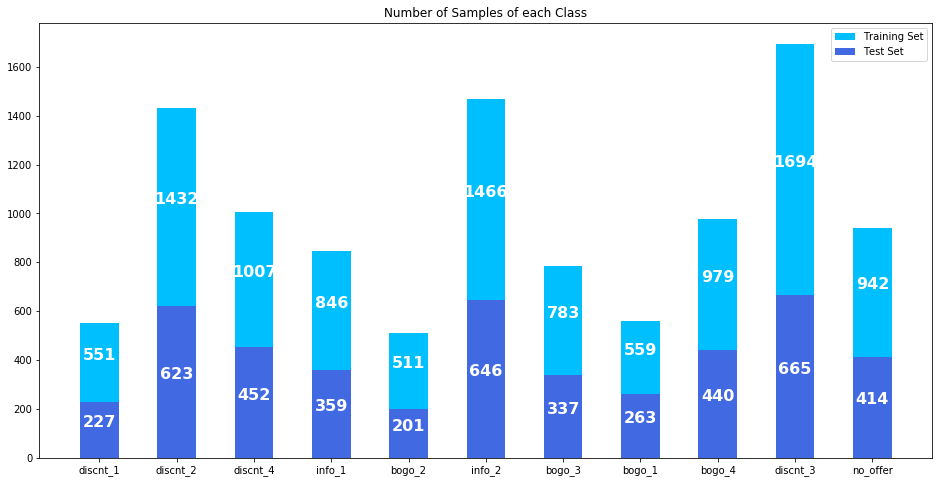

In [39]:
train_cnt = []
for j in range(11):
    train_cnt.append(y_train[:, j].sum())

test_cnt = []
for j in range(11):
    test_cnt.append(y_test[:, j].sum())

plt.figure(figsize=(16, 8))

ax1 = plt.bar(cls_labels, train_cnt, width=0.5, color='deepskyblue',
              label='Training Set', align='center')
ax2 = plt.bar(cls_labels, test_cnt, width=0.5, color='royalblue',
              label='Test Set', align='center')

for r1, r2 in zip(ax2, ax1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    
    plt.text(r1.get_x() + r1.get_width() / 2., 
             h1 / 2., 
             "%d" % h1, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")
    
    plt.text(r2.get_x() + r2.get_width() / 2., 
             h1 + (h2 - h1) / 2., 
             "%d" % h2, 
             ha="center", va="bottom", color="white", 
             fontsize=16, fontweight="bold")

plt.legend(loc='upper right')
plt.title('Number of Samples of each Class')

### Feature Significance

Now that we've alreadycreate the training set and the test set, let's check feature significance to identify the most influencial factors in coffee buying.

My approach to this is PCA.

/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


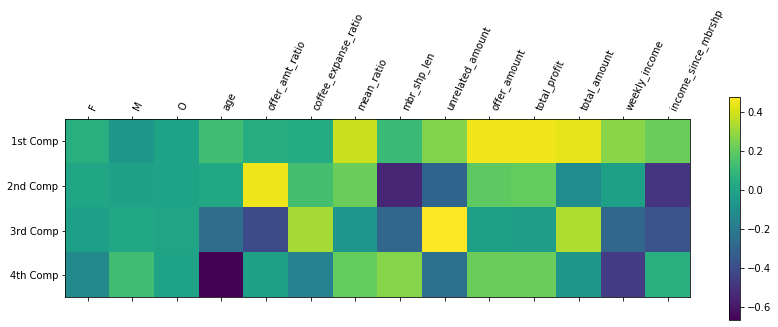

In [40]:
pca = PCA(n_components=4)
pca.fit(X) 

X_pca = pca.transform(X) 

ex_variance=np.var(X_pca, axis=0)
ex_variance_ratio = ex_variance / np.sum(ex_variance)

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1, 2, 3],
           ['1st Comp', '2nd Comp', '3rd Comp', '4th Comp'],
           fontsize=10)
plt.colorbar()
plt.xticks(range(len(feat_list)), feat_list, rotation=65, ha='left')
plt.tight_layout()
plt.show()

From the plot above we can see that, excluding engineered new features, e.g. offer amount, profit, ratio, et c, the most influencial factor to the 1st and 2nd component is `weekly_income` and `age`. These two factors, from our life experience, are also associated. From a statistical perspective, people's income does tend to increase with their age.

Also, we notice that `female` is more influencial than the other two gender.

### Helper Functions

In [41]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    
    model = model.fit(X_train, y_train)
    
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    print(classification_report(y_test, predictions_test,
                                target_names=cls_labels))

In [42]:
def recommand_offer(model, X, num_offer=3):
    """
    inputs:
       - model: the model for prediction
       - X: customer features
       - num_offer: the number of best offer to return

    outputs:
       - best_offer: list of best offer
    """
    best_offer = []
    for i in range(X.shape[0]):
        y_pred = model.predict(X[i,:])
        best_idx = np.argpartition(y_pred, -num_offer)[-num_offer:]
        best_offer.append(np.array(
                list(reversed_offer_dict.values()))[best_idx])

    return np.array(best_offer)

### Performance Metrics

From plots in previous sessions, we can see that given data is imbalanced, the most popular offer has triple amount of samples comparing to the least popular one. This should be taken into consideration of metrics selection.

As we are training a model to predict best offer for given customer, finding the best offer significantly outweights avoiding the worst offer. So, while accuracy and F1 score are both very useful, we can lean a bit more on accuracy.

For starters, we will use `sklearn.metrics.classification_report`, later, we can still have some more exploration in metrics.

### Model Building

Here I chose to build a multi-output XGBoost model. The reason for multi-output classifier is the factor of 'no_offer' mentioned previously, in my opinion, adding it as another label rather than simply taking it as the 11th class makes more sense, as the manually assigned feature could be misleading for the model. 

As for classifier types, XGBoost and RandomForest are both used.

In [43]:
xgb_clf = MultiOutputClassifier(
              XGBClassifier(max_depth=15,
                            gamma=5.0,
                            learning_rate=0.5,
                            min_child_weight=1,
                            subsample=1.0))

train_predict(xgb_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    discnt_1       0.51      0.11      0.19       227
    discnt_2       0.47      0.12      0.19       623
    discnt_4       0.16      0.02      0.03       452
      info_1       0.33      0.05      0.09       359
      bogo_2       0.30      0.06      0.10       201
      info_2       0.51      0.21      0.29       646
      bogo_3       0.38      0.13      0.20       337
      bogo_1       0.42      0.08      0.14       263
      bogo_4       0.55      0.20      0.29       440
    discnt_3       0.44      0.13      0.20       665
    no_offer       1.00      1.00      1.00       414

   micro avg       0.60      0.20      0.30      4627
   macro avg       0.46      0.19      0.25      4627
weighted avg       0.47      0.20      0.26      4627
 samples avg       0.19      0.16      0.17      4627



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
rf_clf = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1,
                                                      random_state=36))

train_predict(rf_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    discnt_1       0.50      0.01      0.02       227
    discnt_2       0.00      0.00      0.00       623
    discnt_4       0.00      0.00      0.00       452
      info_1       0.67      0.02      0.03       359
      bogo_2       0.75      0.01      0.03       201
      info_2       0.71      0.10      0.17       646
      bogo_3       0.48      0.04      0.08       337
      bogo_1       0.33      0.01      0.01       263
      bogo_4       0.59      0.04      0.07       440
    discnt_3       0.38      0.01      0.03       665
    no_offer       1.00      1.00      1.00       414

   micro avg       0.87      0.11      0.20      4627
   macro avg       0.49      0.11      0.13      4627
weighted avg       0.46      0.11      0.13      4627
 samples avg       0.12      0.07      0.09      4627



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From above results, we can see that both model performed accetably well, while the RandomForestClassifier came up on top.

On thing worth noticing here is that both classifier perform poorly on 'discnt_4'. Let's take a look on the offer and the portfolio data again.

In [45]:
print('Offer - discnt_4\n')
print(portfolio.iloc[5])
portfolio.head(10)

Offer - discnt_4

reward                                       3
channels          [web, email, mobile, social]
difficulty                                   7
duration                                     7
offer_type                            discount
id            2298d6c36e964ae4a3e7e9706d1fb8c2
Name: 5, dtype: object


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


We can see that 'discnt_4' is actually among the worst profitable offers. Finishing this offer with default difficulty creates a profit of $4. If we are going to due with the low accuracy here, we probabily want to start from the profit calculation method that decides the `best_offer` column in training data.

But here, let's leave that for another day, and try something that improves the current model. 

### Model Tuning

The one thing we can always do in this kind of situations, is to run a grid search for the best combination of parameters.

The grid search for both models will take the weighted f1-score as metric. It calculate F1 score for each class independently but when it adds them together uses a weight that depends on the number of true labels of each class. In our case here, classes are imbalanced, weighted f1-score can show us better how the model performs.

For the XGBoost Classifier built above, we can tune the following parameters:

* `max_depth`: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

* `learning_rate`: the multiplier in weight update.

* `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

* `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.


In [46]:
xgb_params = {'estimator__max_depth'       : range(10, 31, 5),
              'estimator__learning_rate'   : [0.5, 1.0],
              'estimator__min_child_weight': np.arange(2, 5, 1),
              'estimator__gamma'           : np.arange(3.5, 6, 0.5)}

xgb_gs = GridSearchCV(
                 MultiOutputClassifier(
                     XGBClassifier()),
                 param_grid=xgb_params,
                 scoring='f1_weighted',
                 n_jobs=16,
                 verbose=7
         )

In [47]:
xgb_gs.fit(X_train, y_train)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:  3.6min
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  6.1min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:  9.4min
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed: 13.1min
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed: 17.3min
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed: 22.6min
[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed: 27.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     gamma=None,
                                                                     gpu_id=None,
                                                                     importance_type='gain',
                                                                     interaction_constraints=None,
                                                                     learning_rate=None,
                                                                     ma

In [48]:
xgb_gs.best_params_

{'estimator__gamma': 5.5,
 'estimator__learning_rate': 1.0,
 'estimator__max_depth': 20,
 'estimator__min_child_weight': 2}

For the Random Forest Classifier, we can tune the following parameters:

* `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* `n_estimators`: the number of trees(by default `DecisionTreeClassifier`) in the forest.

* `min_sample_split`: The minimum number of samples required to split an internal node.

* `min_sample_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

In [49]:
rf_params = {'estimator__n_estimators'     : range(50, 301, 25),
             'estimator__min_samples_split': range(1, 6, 2),
             'estimator__min_samples_leaf' : range(1, 3, 1),
             'estimator__max_depth'        : range(20, 41, 10)}

rf_gs = GridSearchCV(
                MultiOutputClassifier(
                    RandomForestClassifier(n_jobs=-1, 
                                           random_state=36)),
                param_grid=rf_params,
                scoring='f1_weighted',
                n_jobs=16,
                verbose=7
         )

In [50]:
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  4.1min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:  6.0min
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:  8.5min
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed: 12.8min
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed: 15.9min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 20.0min
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed: 24.6min
[Parallel(n_jobs=16)]: Done 990 out of 990 | elapsed: 26.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                              ccp_alpha=0.0,
                                                                              class_weight=None,
                                                                              criterion='gini',
                                                                              max_depth=None,
                                                                              max_features='auto',
                                                                              max_leaf_nodes=None,
                                                                              max_samples=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impuri

In [51]:
rf_gs.best_params_

{'estimator__max_depth': 30,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 3,
 'estimator__n_estimators': 50}

After the search, let's check the best model.

In [52]:
best_xgb = xgb_gs.best_estimator_

train_predict(best_xgb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    discnt_1       0.26      0.10      0.15       227
    discnt_2       0.37      0.17      0.24       623
    discnt_4       0.16      0.06      0.09       452
      info_1       0.26      0.11      0.16       359
      bogo_2       0.22      0.11      0.15       201
      info_2       0.40      0.28      0.33       646
      bogo_3       0.32      0.15      0.21       337
      bogo_1       0.37      0.13      0.19       263
      bogo_4       0.45      0.25      0.32       440
    discnt_3       0.33      0.20      0.25       665
    no_offer       1.00      1.00      1.00       414

   micro avg       0.45      0.25      0.32      4627
   macro avg       0.38      0.23      0.28      4627
weighted avg       0.39      0.25      0.29      4627
 samples avg       0.22      0.21      0.20      4627



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
best_rf = rf_gs.best_estimator_

train_predict(best_rf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    discnt_1       0.50      0.02      0.03       227
    discnt_2       0.60      0.01      0.02       623
    discnt_4       0.00      0.00      0.00       452
      info_1       0.73      0.03      0.06       359
      bogo_2       0.67      0.01      0.02       201
      info_2       0.64      0.12      0.20       646
      bogo_3       0.47      0.05      0.09       337
      bogo_1       0.50      0.02      0.03       263
      bogo_4       0.70      0.05      0.10       440
    discnt_3       0.43      0.03      0.05       665
    no_offer       1.00      1.00      1.00       414

   micro avg       0.83      0.12      0.22      4627
   macro avg       0.57      0.12      0.15      4627
weighted avg       0.56      0.12      0.15      4627
 samples avg       0.13      0.08      0.10      4627



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see from above, both classifier gain a few percents of improvements.

Grid searches can always squeeze some extra performance in terms of favourable metrics, at the cost of computation.

To pursue optimal performance, we should always focus more on the following:

* cleaning data

* preprocessing 

* metrics design

Due to time limits, we are not going any further here for now.

---

## Conclusion

This project aims to figure out the following two things:

- The most influencial factors on customers' decision in accepting offers

- The best offers to send to a customer

For the first target, we implemented Principal Component Analysis(PCA) to decompose the feature matrix, and named `income` and `age` as the most influencial factors.

While for the second one, two models were built and fine-tuned to predict best offer to a customer.

But there are much more that are yet to be done.

---

## Next step

Successful data science practice heavily relies on close circle data continuity, this project definitely remind me that.

In these project, we are using data generated by a simulation. Some entries don't make much sense, for example, the offer that is completed before being viewed. This raised the question of how these events are flaged. 

Also, the `channels` factor is hard to use without knowing how the offers are viewed, and the cost of sending via different channels, hence, we can't give any convincing result on that. 

As for what have been done in the project, one thing that needs more attention, is the method that calculates profits from offers. We need more data catagories to model the actual difficulties of different offers, especially informational offers. Leaving their difficulty to 0, is actually a bias in profit against other offer types.

General business understanding gives us a better idea on what data to collect, how to collect, clean and preprocess the data. Then statistical and machine learning techniques can kick in to demonstrate how the business is running, and what can be done to improve. When we setup experiments on improvement plans, a new cycle of data science is started.

One last thing to mention is that coding can always be improved, even though we usually have software engineer colleagues who are dedicate to robust and concise coding.

In [55]:
!jupyter nbconvert Starbucks_Capstone_notebook.ipynb --to html

[NbConvertApp] Converting notebook Starbucks_Capstone_notebook.ipynb to html
[NbConvertApp] Writing 745263 bytes to Starbucks_Capstone_notebook.html
